# References 
- https://scikit-learn.org/stable/modules/outlier_detection.html
- https://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_housing.html#sphx-glr-auto-examples-applications-plot-outlier-detection-housing-py

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

energy_grad = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190425_features_energygrad.txt')
geo_topo = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190425_features_geo_topo.txt')
other = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190425_features_otherinfo.txt')
mig = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190425_features_mig.csv')
da = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190425_features_dihedral_ang.txt')

# mig_sign.columns = mig_sign.columns.str.strip()
energy_grad.columns = energy_grad.columns.str.strip()
geo_topo.columns = geo_topo.columns.str.strip()
other.columns = other.columns.str.strip()
mig.columns = mig.columns.str.strip()
da.columns = da.columns.str.strip()

geo_topo = geo_topo.astype('float')
other = other.astype('float')
da = da.astype('float')

da_len = pd.concat([da.iloc[:,:3], da.iloc[:,6:9]], axis=1)
da_num = pd.concat([da.iloc[:,3:6], da.iloc[:,9:]], axis=1)

an4_face_centro = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190425_an4_face_centroids.csv', names=['x', 'y', 'z'])

### EDA
- If using dihedral angles, then need to filter out nans

In [2]:
# da_len.iloc[:,:3] -= 120.0 
# data = pd.concat([geo_topo.iloc[:,[0,1,2,5,6,7]], geo_topo.iloc[:,[10,11,3,4,8,9]], da_len, other], axis=1)
# data.columns = np.insert(data.columns[1:].values, [0], 'mig_left')
# data = data.mask(~other['not_twin_an4'].astype(bool))


data = pd.concat([geo_topo.iloc[:, 5] / geo_topo.iloc[:, 0], an4_face_centro], axis=1)
data = data.mask(np.abs(geo_topo['A_an4']) < 1)

data = data.dropna()
data.rename(columns={data.columns[0]: 'area_diff_frac'},inplace=True)
data.info()

# data.iloc[:,3] = np.abs(data.iloc[:,3])

# data_normed =  data / data.max(axis=0) * 10
# plotCorrelationMatrix(data_normed, 'corr')
data.columns.tolist()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6935 entries, 0 to 6941
Data columns (total 4 columns):
area_diff_frac    6935 non-null float64
x                 6935 non-null float64
y                 6935 non-null float64
z                 6935 non-null float64
dtypes: float64(4)
memory usage: 270.9 KB


['area_diff_frac', 'x', 'y', 'z']

## Isolation Forest

In [3]:
from sklearn.ensemble import IsolationForest

# y = np.abs(data.iloc[:, 3])
# X = data.drop(['A_diff', 'fMs_diff'], axis=1)
simple = data


# !!!!!!!!!!!!!!!!! adjust sample_weight !!!!!!!!!!!!!!!!!
clf = IsolationForest(contamination=0.01, random_state=0)
normal_if = clf.fit_predict(data)

fname = 'IF_simple.png'

/Users/xiaotingzhong/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/xiaotingzhong/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


## Local Outlier Factor
- n_neighbors
    - greater than the minimum number of samples a cluster has to contain
    - smaller than the maximum number of close by samples that can potentially be local outliers
    - taking n_neighbors=20 appears to work well in general.

In [4]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
normal_lof = clf.fit_predict(data)

fname = 'LOF_data.png'

## Robust Covariance

In [5]:
from sklearn.covariance import EllipticEnvelope

clf = EllipticEnvelope(contamination=0.01)
normal_rc = clf.fit_predict(data)

fname = 'RC_data.png'

In [173]:
print sum(normal_if<0), sum(normal_lof<0), sum(normal_rc<0)
print sum(np.all(np.vstack([normal_if<0, normal_lof<0, normal_rc<0]), axis=0))

# print sum(np.all(np.vstack([normal_if, normal_lof, normal_rc]), axis=0))
# print sum(normal_if>0 & normal_lof>0)

# sum(np.array([1, -1]) & np.array([-1, 1]))

70 70 70
19


## Plot results

16


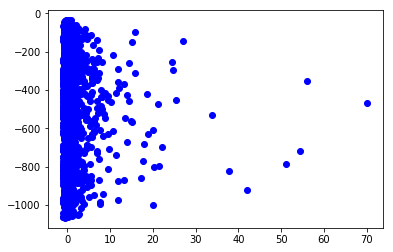

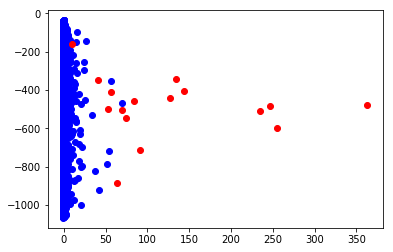

In [6]:
# --------------------------------------------------------
mask_abnormal = np.all(np.vstack([normal_if<0, normal_lof<0, normal_rc<0]), axis=0)
print sum(mask_abnormal)
fname = 'allthree_data.png'

points_normal = simple[~mask_abnormal]
points_abnormal = simple[mask_abnormal]

# --------------------------------------------------------
# mask_normal = (normal == 1)

# points_normal = simple[mask_normal]
# points_abnormal = simple[~mask_normal]



# --------------------------------------------------------
plt.figure()
plt.plot(points_normal.iloc[:,0], points_normal.iloc[:,1], 'bo')

plt.figure()
plt.plot(points_normal.iloc[:,0], points_normal.iloc[:,1], 'bo')
plt.plot(points_abnormal.iloc[:,0], points_abnormal.iloc[:,1], 'ro')
plt.savefig(fname, dpi=300)

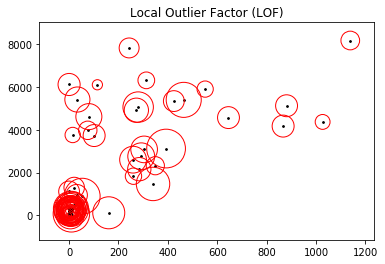

In [100]:

X = simple
X_scores = clf.negative_outlier_factor_


plt.title("Local Outlier Factor (LOF)")
plt.scatter(X.iloc[~mask_normal, 0], X.iloc[~mask_normal, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X.iloc[~mask_normal, 0], X.iloc[~mask_normal, 1], s=10000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')


## Random Forest
- Classify normal & abnormal data, for isolation forest feature importance

In [20]:
from xgboost.sklearn import XGBClassifier

xgb1 = XGBClassifier(
                     num_class = 2,
                     learning_rate =0.01,
                     n_estimators=100,
                     max_depth=3,
#                      min_child_weight=1,
                     gamma=0,
                     colsample_bytree=0.3,
                     objective='multi:softmax',
                     scale_pos_weight=1,
                     seed=3
                    )
y = mask_abnormal.astype(int)
X = data.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
xgb1.fit(X_train, y_train, eval_metric='auc')

print 'training score =', np.round(xgb1.score(X_train, y_train), 3), 'test score =', np.round(xgb1.score(X_test, y_test), 3)
print 'test report'
print classification_report(y_test, xgb1.predict(X_test))

training score = 0.998 test score = 0.996
test report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1381
           2       0.00      0.00      0.00         6

   micro avg       1.00      1.00      1.00      1387
   macro avg       0.50      0.50      0.50      1387
weighted avg       0.99      1.00      0.99      1387



/Users/xiaotingzhong/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
y.shape[0]

6935